In [1]:
import pickle
import numpy
import keras
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization as BN

import h5py
import random
import numpy as np
from collections import defaultdict
from minibatcher import MiniBatcher
import matplotlib.pylab as plt
%matplotlib inline

Using gpu device 0: GeForce GTX 980M (CNMeM is disabled)


In [2]:
num_authors=40

### Full network definition
#### Note that this model goes all the way to the end.

In [3]:
model = Sequential()
model.add(Convolution2D(48, 12, 12,
                    border_mode='full',
                    input_shape=(1, 120, 120),
                    activation='relu'))
#model.add(Activation('relu'))

model.add(Convolution2D(48, 6, 6, activation='relu'))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Convolution2D(128, 6, 6, border_mode = 'full', activation='relu'))
#model.add(BN(epsilon=1e-6))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Convolution2D(128, 3, 3, border_mode = 'full', activation='relu'))
#model.add(BN(epsilon=1e-6))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


#model.add(Convolution2D(128, 6, 6, border_mode = 'full', activation='relu'))
#model.add(BN(epsilon=1e-6))
#model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_authors))
model.add(Activation('softmax'))

In [4]:
model.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [5]:
# weights = h5py.File('authors_40_forms_per_author_15_epoch_8100.hdf5.hdf5')
model.load_weights('/work/data/authors_40_forms_per_author_15_epoch_8100.hdf5.hdf5')

### Data shingling software written by Yonas

In [6]:
hdf5_file = '/work/data/output_shingles_sparse.hdf5'

num_forms_per_author=15
fIn = h5py.File(hdf5_file, 'r')
authors = []

# Filter on number of forms per author
for author in fIn.keys():
    if len(fIn[author]) > num_forms_per_author:
        authors.append(author)

if len(authors) < num_authors:
    raise ValueError("There are only %d authors with more than %d forms"%(len(authors), num_forms_per_author))


keys = []
# Get all the keys from our hdf5 file
for author in authors[:num_authors]: # Limit us to num_authors
    forms = list(fIn[author])
    for form in forms[:num_forms_per_author]: # Limit us to num_form_per_author
        for line_name in fIn[author][form].keys():
            for shingle in range(fIn[author][form][line_name].shape[0]):
                keys.append([(author,form,line_name), shingle])

# Normalization function which scales values from 0 (white) to 1 (black)
normalize = lambda x: 1.0 - x.astype(np.float32)/255.0

m = MiniBatcher(fIn, keys,normalize=normalize, batch_size=32, min_shingles=20*7*num_forms_per_author)

m.batch_size = 32*20
m.set_mode(MiniBatcher.TEST)
[X_test, Y_test] = m.get_batch()
X_test = np.expand_dims(X_test, 1)
Y_test = to_categorical(Y_test, num_authors)
print 'test_size:', X_test.shape, Y_test.shape

m.batch_size = 32*100
m.set_mode(MiniBatcher.TRAIN)

Key Depth:  3
Sample Key: (u'a01', u'a01-000u', u'a01-000u-00.png')
test_size: (640, 1, 120, 120) (640, 40)


### Partial network generation function

In [7]:
def partialnetwork(model, layernum):
    ''' def partialnetwork(model, layernum):
          model: the original full model
          layernum: the last layer of the neural network that you want to evaluate
        
          returns partial_model: the resulting neural network
    '''
    
    for i,l in enumerate(model.layers):
        print str(i+1)+": "+str(l)
    print "You are looking at "+str(model.layers[layernum-1])
    
    if len(model.layers) < layernum:
        return model
    
    rmodel = Sequential()
    for i in xrange(layernum):
        rmodel.add(model.layers[i])
        rmodel.layers[i].set_weights( model.layers[i].get_weights() )
    
    rmodel.compile(loss='mse', optimizer='adadelta')
    return rmodel

In [8]:
rmodel = partialnetwork(model, 7)

1: <keras.layers.convolutional.Convolution2D object at 0x7fe5bcc6b550>
2: <keras.layers.convolutional.Convolution2D object at 0x7fe5bcc035d0>
3: <keras.layers.convolutional.MaxPooling2D object at 0x7fe5bcc27c10>
4: <keras.layers.core.Dropout object at 0x7fe5bcc03550>
5: <keras.layers.convolutional.Convolution2D object at 0x7fe5bcc27d50>
6: <keras.layers.convolutional.MaxPooling2D object at 0x7fe5bcc301d0>
7: <keras.layers.convolutional.Convolution2D object at 0x7fe5bcc27d90>
8: <keras.layers.convolutional.MaxPooling2D object at 0x7fe5bcc30790>
9: <keras.layers.core.Dropout object at 0x7fe5bcc30310>
10: <keras.layers.core.Flatten object at 0x7fe5bcc30910>
11: <keras.layers.core.Dense object at 0x7fe5bcc30990>
12: <keras.layers.core.Activation object at 0x7fe5bcc309d0>
13: <keras.layers.core.Dropout object at 0x7fe609a972d0>
14: <keras.layers.core.Dense object at 0x7fe608df3290>
15: <keras.layers.core.Activation object at 0x7fe5bcc32cd0>
You are looking at <keras.layers.convolutional.Con

### Forward propagation to get the activations of the network. Support for dense layers only

In [9]:
def forwardact(model, mbatch, numbatches, verbosity=1):
    
    ''' def forwardviz(model, mbatch, numbatches, verbosity=1):
          model: the model to be vizualized (can be partial)
          mbatch: minibatcher from Yonas's code
          numbatches: number of batches to run (stopping point)
          verbosity: verbosity in evaluating individual batches
          
          returns activations.
        
        Get the forward activations of model, using
        large scale modeling with data from minibatcher mbatch
    '''
    
    # Reset the seed. We're going to want to go back through to collect the training images.
    random.seed(128)
    
    rashape = np.array(model.output_shape)
    rashape[0]=0
    activations = np.zeros(rashape)
    for i in range(numbatches):
        print "Loading data into memory & GPUs"
        (X_train, Y_train) = mbatch.get_batch()
        X_train = np.expand_dims(X_train, 1)
        Y_train = to_categorical(Y_train, num_authors)
        print "Beginning forward propagation on batch "+str(i)
        activations = np.append( activations, model.predict(X_train, verbose=verbosity), axis=0 )
        print "Progress = "+str( (i+0.01-0.01) / numbatches)
        
    return activations

### Forward propagation lite (for convolutions). Really only calls predict w/model.

In [10]:
def forward2viz(model, X_train, verbosity=1):
    
    ''' def forwardviz(model, mbatch, numbatches, verbosity=1):
          model: the model to be vizualized (can be partial)
          mbatch: minibatcher from Yonas's code
          numbatches: number of batches to run (stopping point)
          verbosity: verbosity in evaluating individual batches
          
          returns activations.
        
        Get the forward activations of model, using
        large scale modeling with data from minibatcher mbatch
    '''
    activations = model.predict(X_train, verbose=verbosity)

    return activations

In [29]:
(X_train, Y_train) = m.get_batch()
X_train = np.expand_dims(X_train, 1)
Y_train = to_categorical(Y_train, num_authors)
activations = forward2viz(rmodel, X_train, verbosity=1)

3200/3200 [==============================] - 73s    


### Heatmap generation to get the most relevant portions of the image.

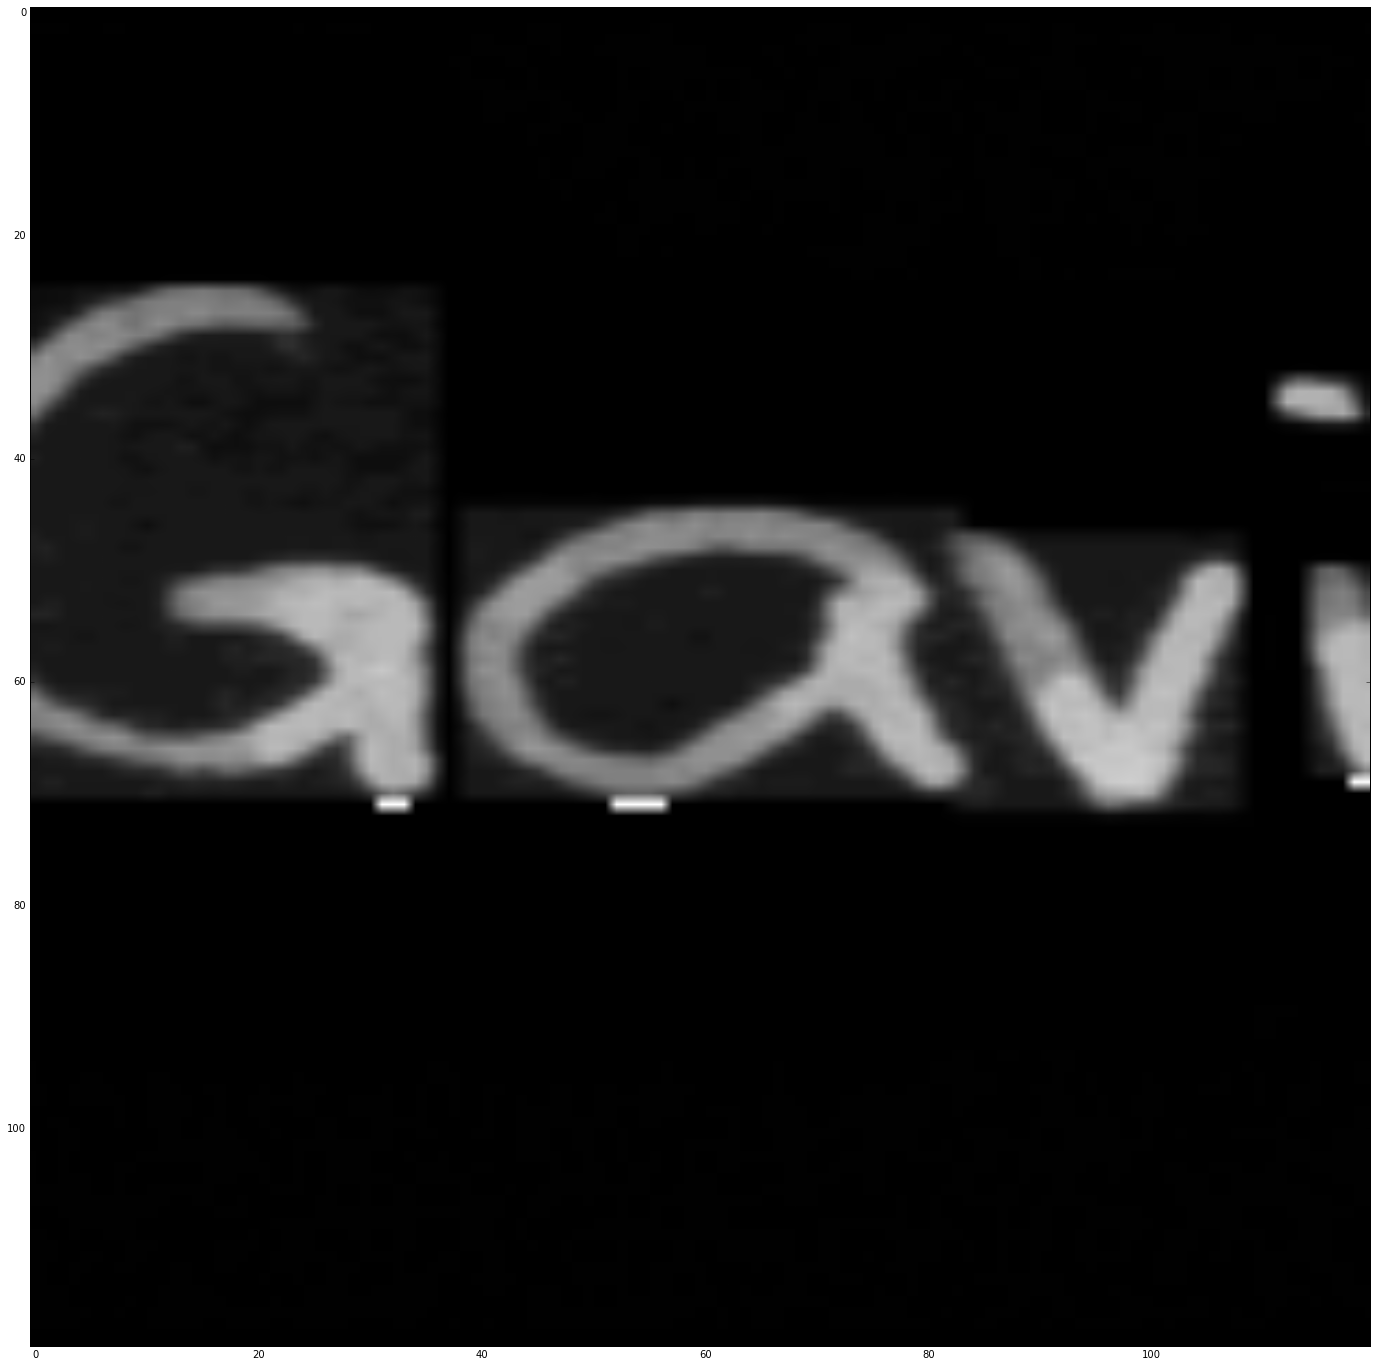

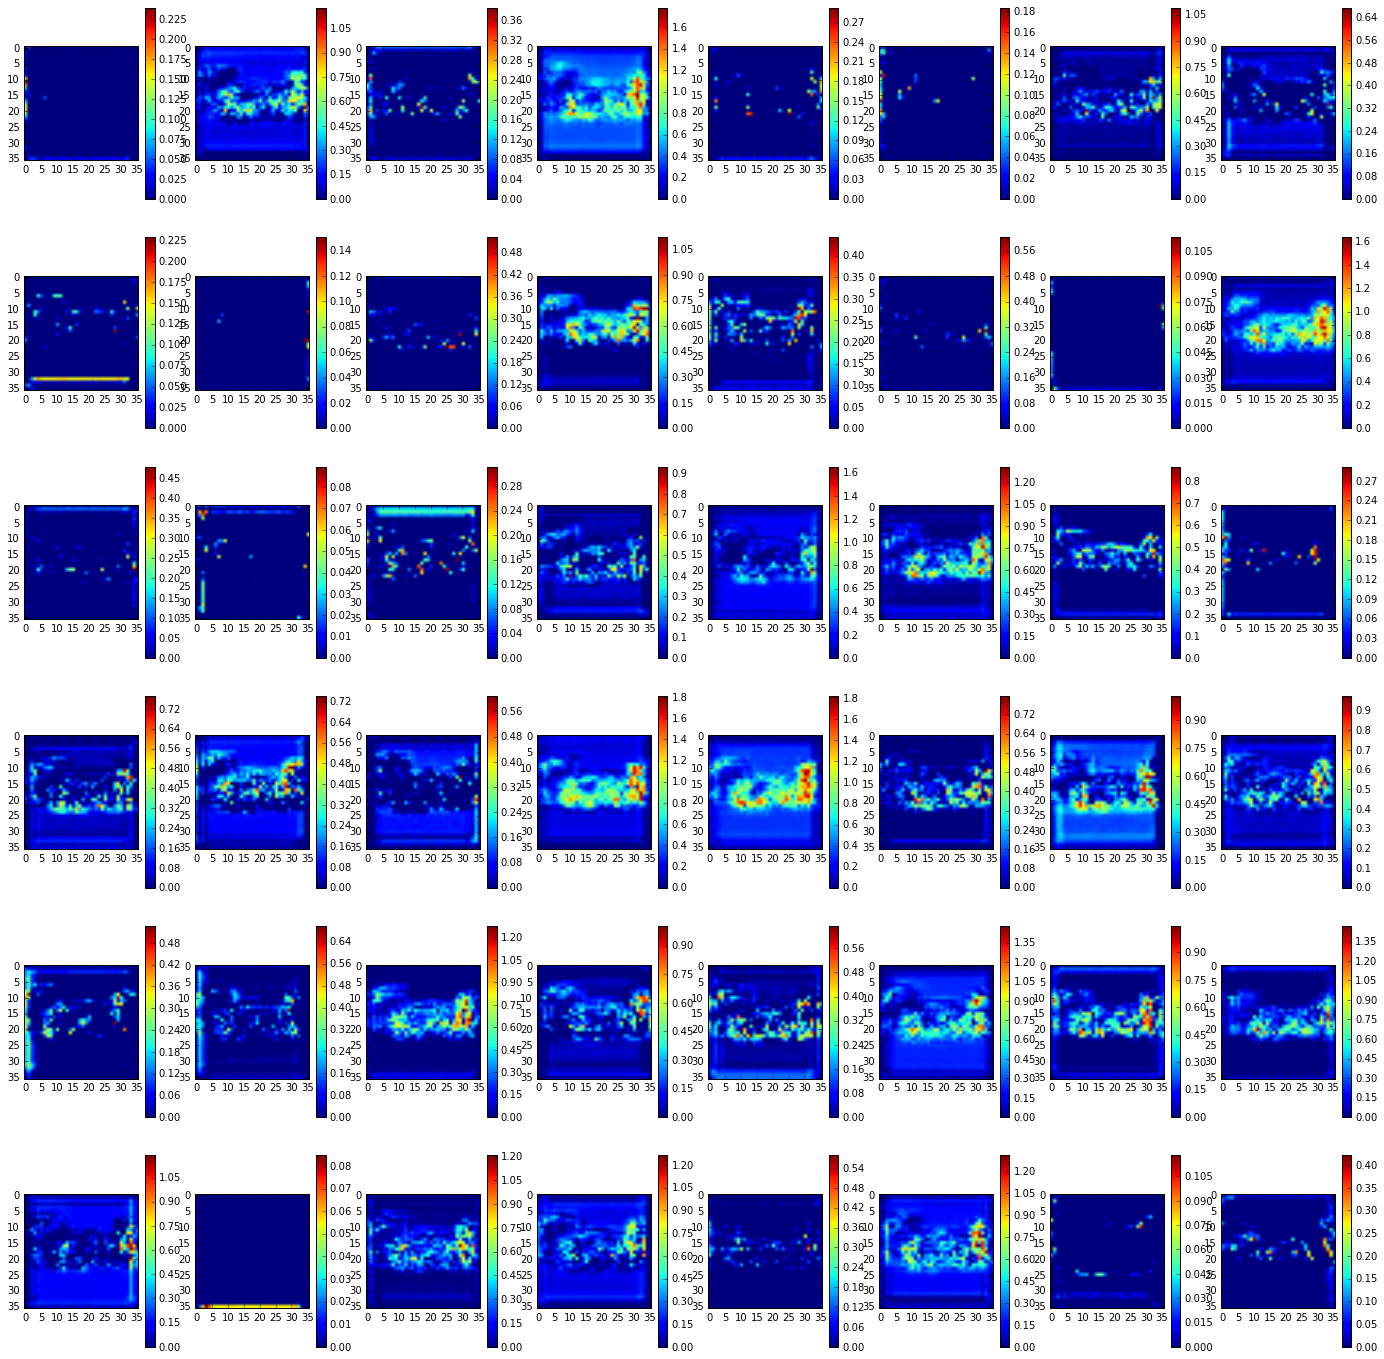

In [31]:
X_train.shape

# Image that we're looking at
i2look=5


plt.imshow(X_train[i2look,0], cmap=plt.get_cmap('gray'))
# plt.imshow(activations[i2look, 34])
plt.rcParams['figure.figsize'] = (24.0, 24.0)
fig, axs = plt.subplots(6,8)
for i in range(48):
    plt.subplot(6,8,i+1)
    plt.imshow(activations[i2look,i]) # , plt.get_cmap('gray'))
    plt.colorbar()


### Verify that the batches are in fact identical when resetting seed

In [ ]:
# First verify that the batches are in fact identical.
random.seed(122)
m.cycle_batch()
(X1, Y1) = m.get_batch()
(X1, Y1) = m.get_batch()
print "Comparisons Test"
random.seed(122)
(X2, Y2) = m.get_batch()
(X2, Y2) = m.get_batch()
(X2, Y2) = m.get_batch()
print "Reference Test"

### Get the activations for layer 14

In [13]:
random.seed(122)
dmodel = partialnetwork(model, 14)
activations = forwardact(dmodel, m, 2)

1: <keras.layers.convolutional.Convolution2D object at 0x7fe5bcc6b550>
2: <keras.layers.convolutional.Convolution2D object at 0x7fe5bcc035d0>
3: <keras.layers.convolutional.MaxPooling2D object at 0x7fe5bcc27c10>
4: <keras.layers.core.Dropout object at 0x7fe5bcc03550>
5: <keras.layers.convolutional.Convolution2D object at 0x7fe5bcc27d50>
6: <keras.layers.convolutional.MaxPooling2D object at 0x7fe5bcc301d0>
7: <keras.layers.convolutional.Convolution2D object at 0x7fe5bcc27d90>
8: <keras.layers.convolutional.MaxPooling2D object at 0x7fe5bcc30790>
9: <keras.layers.core.Dropout object at 0x7fe5bcc30310>
10: <keras.layers.core.Flatten object at 0x7fe5bcc30910>
11: <keras.layers.core.Dense object at 0x7fe5bcc30990>
12: <keras.layers.core.Activation object at 0x7fe5bcc309d0>
13: <keras.layers.core.Dropout object at 0x7fe609a972d0>
14: <keras.layers.core.Dense object at 0x7fe608df3290>
15: <keras.layers.core.Activation object at 0x7fe5bcc32cd0>
You are looking at <keras.layers.core.Dense object

### Find the top activation indices

In [ ]:
neuron = 35
numintop = 5
topactivations = np.zeros((activations.shape[1],numintop))
for neuron in xrange(activations.shape[1]):
    topactivations[neuron,:] = activations[:,neuron].argsort()[-numintop:][::-1]

### Collect the data/images that activate a neuron the most

In [25]:
def forwardviz(model, topk, mbatch, numbatches, verbosity=1):
    
    ''' def forwardviz(model, mbatch, numbatches, verbosity=1):
          model: the model to be vizualized (can be partial)
          mbatch: minibatcher from Yonas's code
          numbatches: number of batches to run (stopping point)
          verbosity: verbosity in evaluating individual batches
          
          returns activations.
        
        Get the forward activations of model, using
        large scale modeling with data from minibatcher mbatch
    '''
    
    sx=120
    sy=120
    
    topimages = np.zeros( (topk, model.output_shape[1], sx, sy) )
    
    neurons=model.output_shape[-1]
    topactivations = np.zeros((topk,neurons))
    # For loop going through the batches
    for i in range(numbatches):
        
        # Load the data in
        print "Loading data into memory & GPUs"
        (X_train, Y_train) = mbatch.get_batch()
        X_train = np.expand_dims(X_train, 1)
        Y_train = to_categorical(Y_train, num_authors)
        
        # Predict on the model currently and find the best candidates by firing power
        activations = model.predict(X_train,verbose=verbosity)
        sortactivate = activations.argsort(axis=0)[-topk:][::-1]
        
        # For every neuron, replace the top 8activations if necessary
        for neuron in xrange(neurons):
            
            topcandidates = activations[sortactivate.T[neuron],neuron]
        
            # Replace only those candidates in topactivations that warrant being replaced
            for n, candidate in enumerate(topcandidates):

                minact = topactivations[:,neuron].argmin()
                # If your minimum activation is over any of the candidates, then move onto next candidate

                if topactivations[minact,neuron] > candidate:
                    break
                # Replace your minimum activation with this new candidate and go through the rest
                else:
                    topactivations[minact,neuron] = candidate 
                    topimages[minact,neuron,:,:] = X_train[sortactivate.T[neuron,n],:,:,:].squeeze()
            

        print "Progress = "+str( (i+0.01-0.01) / numbatches * 100)
        
    return topactivations, topimages

In [34]:
topactivations,topimages = forwardviz(dmodel, 5, m, 50, verbosity=1)

Loading data into memory & GPUs
3200/3200 [==============================] - 71s    
0.0,-0.0510255470872
0.0,-0.0341842025518
Progress = 0.0
Loading data into memory & GPUs
3200/3200 [==============================] - 70s    
0.63821721077,0.619662344456
0.776285350323,0.774728894234
0.553360104561,0.540799796581
0.130390137434,0.124496869743
0.464638829231,0.461954802275
0.769383847713,0.766648113728
0.742547273636,0.730414867401
0.634948551655,0.57685571909
0.117946252227,0.106747761369
0.327205181122,0.283097952604
1.14788031578,1.07487344742
0.512016534805,0.471673250198
0.823336601257,0.820009827614
0.22457896173,0.199086844921
0.488947689533,0.477003842592
0.70069617033,0.631107091904
0.581260621548,0.512301146984
0.928117632866,0.91366404295
0.111569017172,0.0820825099945
0.174362421036,0.0971417874098
0.938063561916,0.934189319611
0.528046667576,0.526141285896
0.0,-0.0803788006306
0.697097361088,0.676696658134
0.111384555697,0.110725060105
0.828886032104,0.825028717518
1.25467

(5, 40, 120, 120)

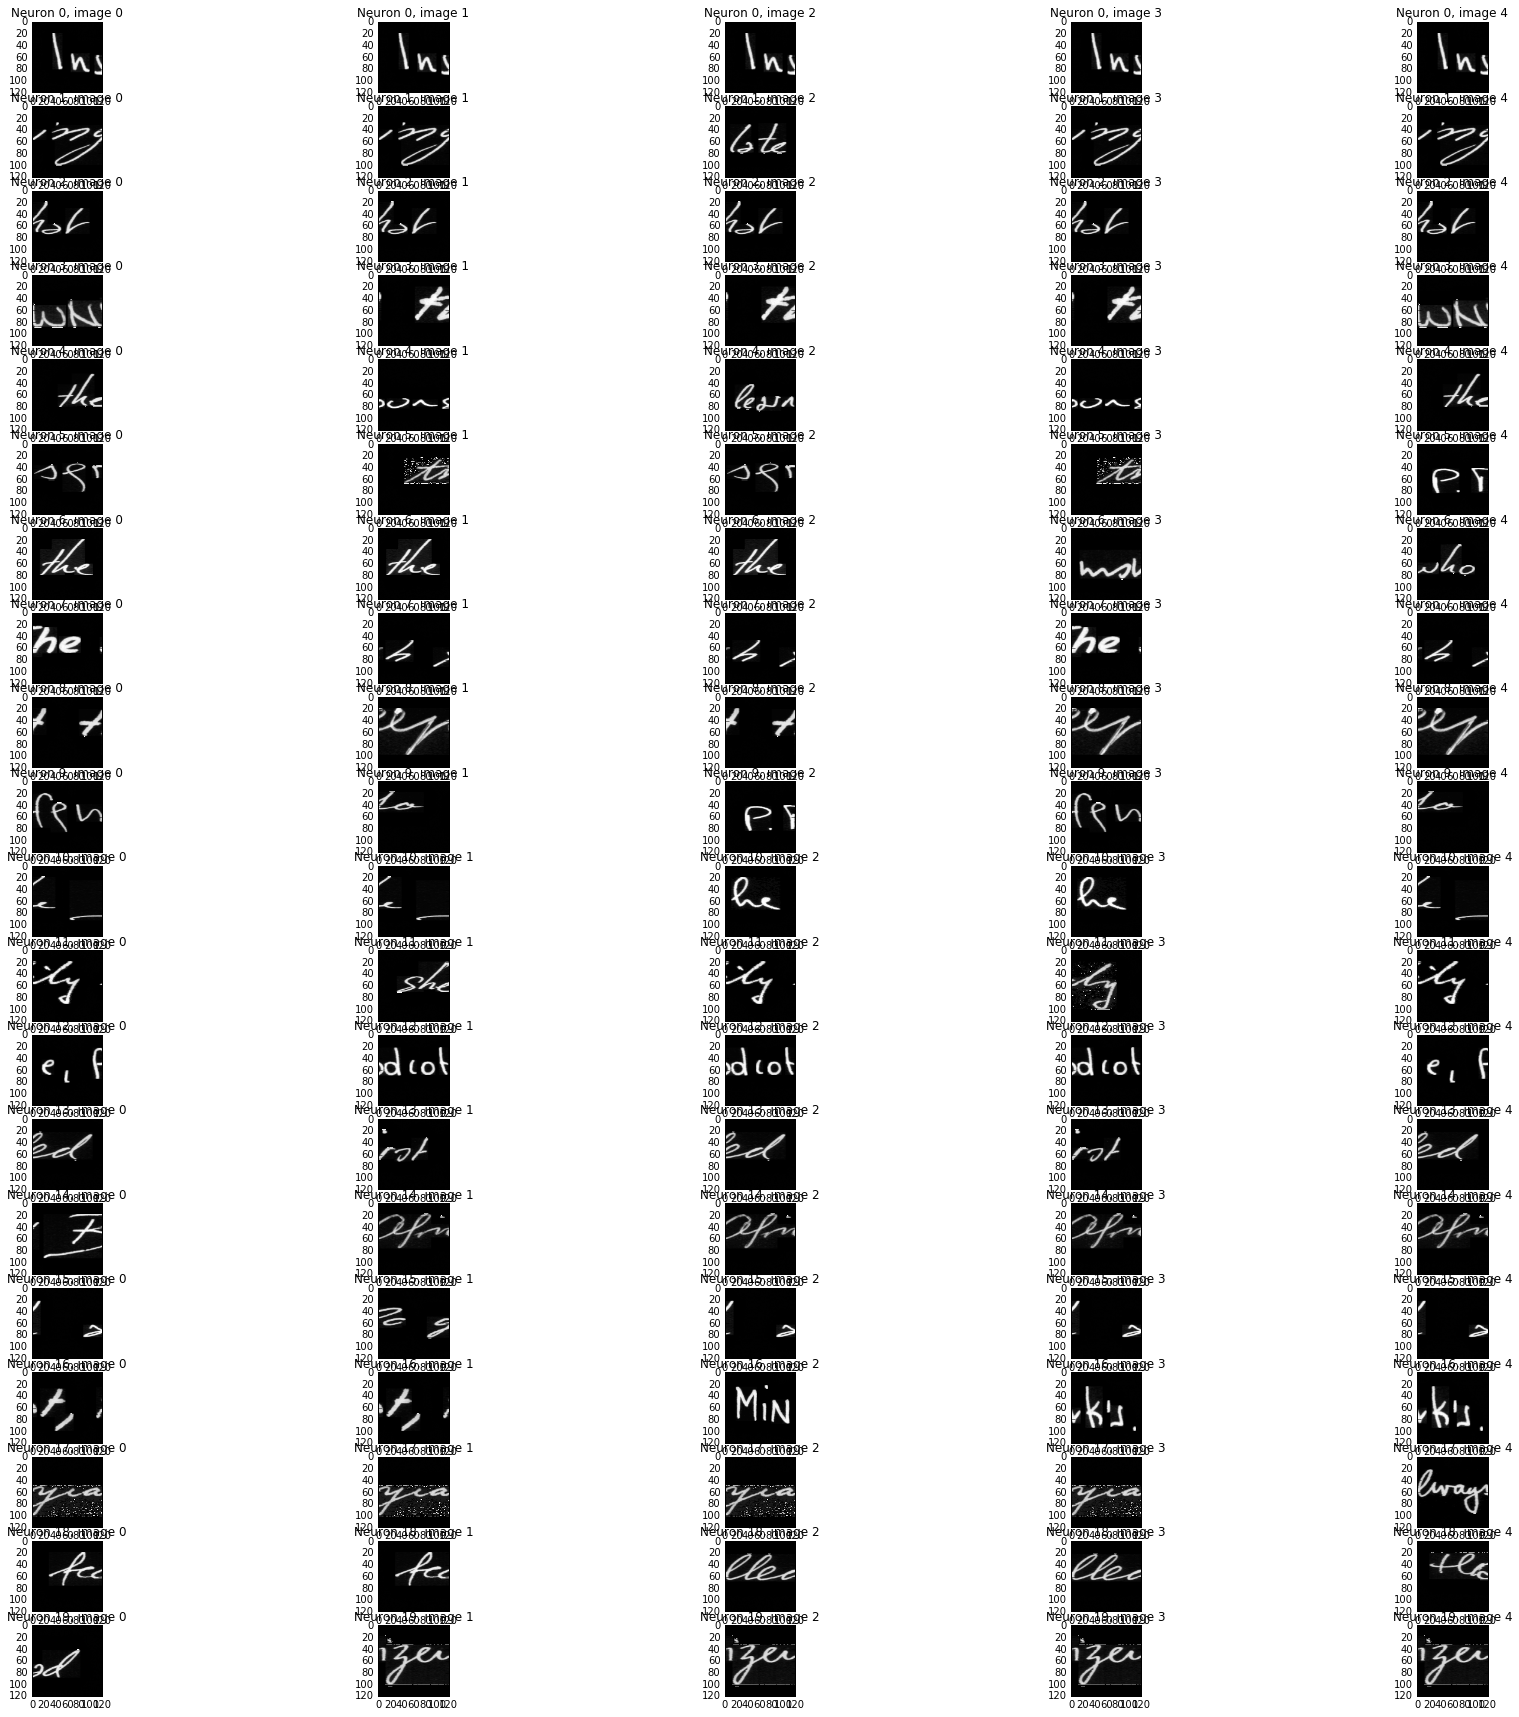

In [57]:
# Which neuron would you like to view?
n2look = 2

plt.rcParams['figure.figsize'] = (30.0, 30.0)
fig, axs = plt.subplots(20,5)
for n2look in xrange(20):
    for ims in range(5):
        plt.subplot(20,5,n2look*5+ims+1)
        plt.imshow(topimages[ims,n2look,:,:], cmap=plt.get_cmap('gray'))
        plt.title('Neuron '+str(n2look)+', image '+str(ims))
topimages.shape